In [2]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

import time
import os, sys
import re
import glob
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
from skimage import color
from skimage import io

#SciAnalysis_PATH='/home/xf11bm/software/SciAnalysis2018C1/'
SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis2018C3'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

from fun_map import *
%matplotlib inline

########## Input 
feature_args = {
                'filename'  : 'Sandro_test_x', 
                'feature_id': 1,  # [*] Specify
                'map_type': 'xy',
                'log10'  : 0,
                'verbose': 1,
               } 

feature_1_args = {'source_dir' : '../thumbnails/',
             'ext' : '.jpg',
             #'pixels' : [[89, 122], [102, 201], [152, 73]],  # [*] Choose pixels
             'pixels' : [[324, 90]],
             'pixels_stat' : 0,     # [*] 'mean', 'max', 'var', or idx
             }

feature_2_args = {'source_dir' : '../circular_average/',
             'ext' : '.dat',
             'data_col' : [0, 2],
             'q_targets' : [1.83], #0.053  # [*] Choose q0 or q0,q1
             'n' : 5     # [*] Choose the half-width (data points) of the peak q
             }

feature_3_args = {'source_dir' : '../linecut_angle/',
             'ext' : '.dat',
             'data_col' : [0, 1],
             'angle_targets': 'max' # 'max' or specify angle 
             }
    
feature_args.update(feature_1_args=feature_1_args, feature_2_args=feature_2_args, feature_3_args=feature_3_args)
infiles, match_re = get_filematch(feature_args)  


Sandro_test_x*.jpg
Considering 54 files...


<IPython.core.display.Javascript object>


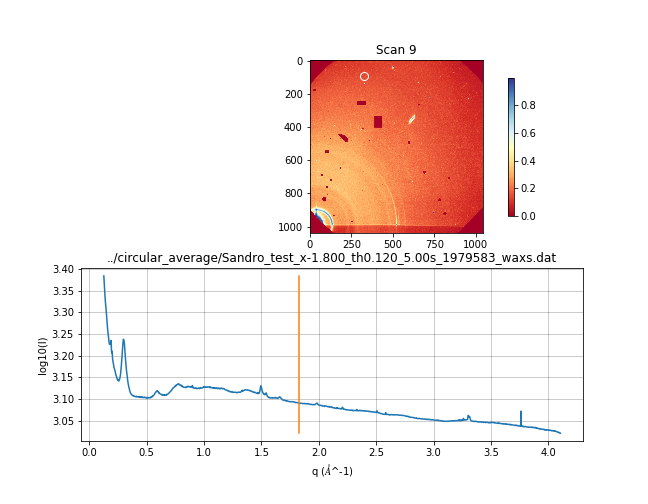

interactive(children=(IntSlider(value=26, description='scan', max=53), Output()), _dom_classes=('widget-intera…

In [3]:
##### Slider for viewing all data                                
%matplotlib nbagg
cmap = 'RdYlBu';  # 'viridis' 'magma' 'RdYlGn' 'RdYlBu' (https://matplotlib.org/examples/color/colormaps_reference.html)
feature_args.update(cmap=cmap)
feature_args.update(verbose=0)
fig = plt.figure(10, figsize=[9,7]); plt.clf()
w_slide = widgets.interactive(plot_scan, scan=(0,len(infiles)-1), feature_args = widgets.fixed(feature_args))
display(w_slide)

counter = Counter()
items = [
    widgets.Button(description='Prev', layout=widgets.Layout(flex='1 1 auto', width='auto'), button_style='primary'),
    widgets.Button(description='Next', layout=widgets.Layout(flex='1 1 auto', width='auto'), button_style='primary'),
 ]
items[0].on_click(partial(button_callback_decr, counter, feature_args))
items[1].on_click(partial(button_callback_incr, counter, feature_args))

widgets.link((w_slide.children[0], 'value'), (counter, 'value'))

box_layout = widgets.Layout(display='flex', flex_flow='row', align_items='stretch',width='70%')
box_auto = widgets.Box(children=items, layout=box_layout)

widgets.VBox([box_auto])

<IPython.core.display.Javascript object>


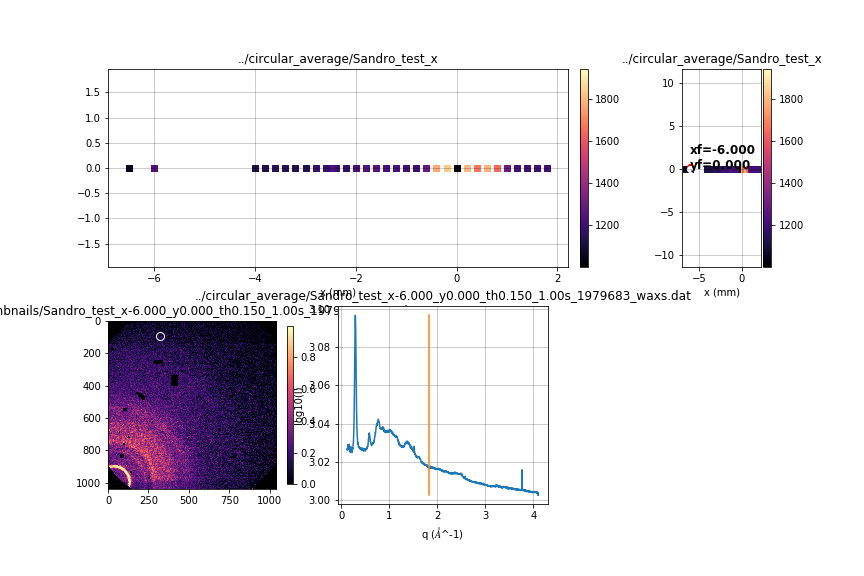

In [4]:
# =============================================================================
# Given x,y and a list of data positions, find the closest point with data
# =============================================================================
##### Click on map to show data
%matplotlib nbagg
fig = plt.figure(20, figsize=[12,8])
fdim = [2, 6]
axis_font = {'fontname':'Arial', 'size':'12', 'weight':'bold'}

feature_args.update(feature_id=2);
feature_args.update(cmap = 'magma')
ax1 = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=5); ax1.cla()
infiles, match_re = get_filematch(feature_args) 
scans, x_pos, y_pos, feature = get_map(infiles, match_re, feature_args) 
plot_map(x_pos, y_pos, feature, feature_args)

pos = []
def onclick(event):   
    xc = event.xdata; 
    yc = event.ydata 
    xf, yf = get_closest([xc, yc], [x_pos, y_pos])
    
    ax2 = plt.subplot2grid((fdim[0], fdim[1]), (0, 5), colspan=1); #ax2.cla()
    plot_map(x_pos, y_pos, feature, feature_args)
    plt.scatter(xc,yc,color='r') # clicked
    plt.scatter(xf,yf,color='w') # position found in the data position list
    ax2.set_aspect('equal')
    ax2.text(xf,yf,'xf={:.3f}\nyf={:.3f}'.format(xf, yf), **axis_font)
    
    for idx in [1, 2]:
        feature_args.update(feature_id=idx); 
        infiles = find_file(xf, yf, feature_args)
        ax = plt.subplot2grid((fdim[0], fdim[1]), (1, (idx-1)*2), colspan=2); #ax3.cla()
        if infiles!=[]: plot_data(infiles[0], feature_args)

    
fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()



In [81]:
########## Plot all feature map
feature_show = [1, 2, 3]
for idx in feature_show:
    feature_args.update(feature_id=idx); 

    ## Find matching files
    infiles, match_re = get_filematch(feature_args)  

    ## Get map
    scans, x_pos, y_pos, feature = get_map(infiles, match_re, feature_args) 
    feature_args.update(val_stat=[np.min(feature), np.max(feature)])

    ## Plot map
    fig = plt.figure(10+feature_args['feature_id'], figsize=[15,5]); plt.clf()
    cmap = plt.get_cmap('viridis');    feature_args.update(cmap=cmap)
    #feature_args.update(val_stat = [0, 20])
    plot_map(x_pos, y_pos, feature, feature_args)
